In [27]:
import numpy as np
from keras.models import Sequential
from keras.layers import Input, Dense, LayerNormalization
from keras.optimizers import Adam, SGD
import keras.backend as K
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics
import sklearn.linear_model
import sklearn.preprocessing
import statistics

In [10]:
def MeanPositiveError(truth, prediction):
    error = truth - prediction
    error = error[error >= 0]
    return np.sum(error)/np.shape(truth)[0]

def keras_mpe(y_true, y_pred):
    error = (y_true - y_pred)
    positive_error = K.sum(error[K.greater_equal(error, 0)])
    negative_error = K.sum(K.sqrt(K.abs(error[K.greater_equal(0.0, error)])))
    
    return 2 * positive_error + negative_error

## Zip Predictor

In [11]:
# Import decompression size .csv
zip_results_df = pd.read_csv("../data/zip_decompression_results.csv")

x = np.array(zip_results_df.compressed_size)
y = np.array(zip_results_df.decompressed_size)

In [56]:
# Train sklearn model
zip_sklearn_model = sklearn.linear_model.LinearRegression(fit_intercept=False)
zip_sklearn_model.fit(x.reshape(-1, 1), y)

y_pred = zip_sklearn_model.predict(x.reshape(-1, 1))

print(f"Line: {zip_sklearn_model.coef_}x + {zip_sklearn_model.intercept_}")
print(f"R^2: {zip_sklearn_model.score(x.reshape(-1, 1), y)}")
print(f"MSE: {sklearn.metrics.mean_squared_error(y, y_pred)}")
print(f"RMSE: {np.sqrt(sklearn.metrics.mean_squared_error(y, y_pred))}")
print(f"MPE: {MeanPositiveError(y, y_pred)}")

Line: [5.88836066]x + -21122719.688942432
R^2: 0.4114918533032038
MSE: 1.3310794749774374e+18
RMSE: 1153724176.2992737
MPE: 124010328.56158382


In [59]:
error = y_pred - y
np.quantile(error, 0.95)

652706588.9033701

In [6]:
# Train keras model

x_sc = sklearn.preprocessing.StandardScaler()
y_sc = sklearn.preprocessing.StandardScaler()
x_scaled = x_sc.fit_transform(x.reshape(-1, 1)).flatten()
y_scaled = y_sc.fit_transform(y.reshape(-1, 1)).flatten()

adam = Adam(lr=0.01)
sgd = SGD(lr=0.01)

zip_keras_model = Sequential()
zip_keras_model.add(Input((1,)))
zip_keras_model.add(Dense(1, activation="linear", use_bias=False))
zip_keras_model.compile(optimizer=sgd, loss=keras_mpe)

zip_keras_model.summary()

history = zip_keras_model.fit(x_scaled, y_scaled,
                              epochs=100)

y_pred = y_sc.inverse_transform(zip_keras_model.predict(x_scaled).reshape(-1, 1)).flatten()

print(f"MSE: {sklearn.metrics.mean_squared_error(y, y_pred) / (10 ** 9)}GB")
print(f"RMSE: {np.sqrt(sklearn.metrics.mean_squared_error(y, y_pred)) / (10 ** 9)}GB")
print(f"MPE: {MeanPositiveError(y, y_pred) / (10 ** 9)}GB")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 1         
Total params: 1
Trainable params: 1
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
53/53 [==============================] - 0s 529us/step - loss: 11.6355
Epoch 2/100
53/53 [==============================] - 0s 451us/step - loss: 10.2784
Epoch 3/100
53/53 [==============================] - 0s 430us/step - loss: 10.0719
Epoch 4/100
53/53 [==============================] - 0s 454us/step - loss: 10.9094
Epoch 5/100
53/53 [==============================] - 0s 460us/step - loss: 9.7637
Epoch 6/100
53/53 [==============================] - 0s 511us/step - loss: 11.7987
Epoch 7/100
53/53 [==============================] - 0s 486us/step - loss: 9.6409
Epoch 8/100
53/53 [==============================] - 0s 455us/step - loss: 11

In [7]:
def zip_keras_predict(x):
    x_scaled = x_sc.transform(x)
    return y_sc.inverse_transform(zip_keras_model.predict(x_scaled).reshape(-1, 1)).flatten()

Text(0, 0.5, 'Decompressed size (bytes)')

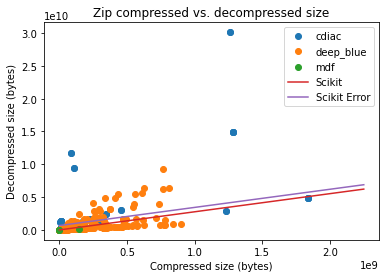

In [67]:
# Visualize compression vs. decompression
x1 = zip_results_df.compressed_size
y1 = zip_results_df.decompressed_size

# Figure 1
for name, group in zip_results_df.groupby("origin"):
    plt.plot(group.compressed_size, group.decompressed_size, marker="o", linestyle="", label=name)

plt.plot(np.array([i for i in range(1, 25*10**8, 25*10**7)]), 
         zip_sklearn_model.predict(np.array([i for i in range(1, 25*10**8, 25*10**7)]).reshape(-1, 1)), 
         label="Scikit")

plt.plot(np.array([i for i in range(1, 25*10**8, 25*10**7)]), 
         zip_sklearn_model.predict(np.array([i for i in range(1, 25*10**8, 25*10**7)]).reshape(-1, 1)) + 668651146.3711116, 
         label="Scikit Error")

# plt.plot(np.array([i for i in range(1, 25*10**8, 25*10**7)]), 
#          zip_keras_predict(np.array([i for i in range(1, 25*10**8, 25*10**7)]).reshape(-1, 1)), 
#          label="Keras")

plt.legend()
plt.title("Zip compressed vs. decompressed size")
plt.xlabel("Compressed size (bytes)")
plt.ylabel("Decompressed size (bytes)")

## Gzip Predictor

In [60]:
# Import decompression size .csv
gzip_results_df = pd.read_csv("../data/gzip_decompression_results.csv")

x = np.array(gzip_results_df.compressed_size)
y = np.array(gzip_results_df.decompressed_size)

In [62]:
# Train sklearn model
gzip_sklearn_model = sklearn.linear_model.LinearRegression(fit_intercept=False)
gzip_sklearn_model.fit(x.reshape(-1, 1), y)

y_pred = gzip_sklearn_model.predict(x.reshape(-1, 1))

print(f"Line: {gzip_sklearn_model.coef_}x + {gzip_sklearn_model.intercept_}")
print(f"R^2: {gzip_sklearn_model.score(x.reshape(-1, 1), y)}")
print(f"MSE: {sklearn.metrics.mean_squared_error(y, y_pred)}")
print(f"RMSE: {np.sqrt(sklearn.metrics.mean_squared_error(y, y_pred))}")
print(f"MPE: {MeanPositiveError(y, y_pred)}")

Line: [2.76372148]x + 0.0
R^2: 0.8473381354511799
MSE: 4.345623941538796e+16
RMSE: 208461601.7768931
MPE: 30692605.71863196


In [74]:
error = y_pred - y
np.quantile(error, 0.95)

7038058.413954257

Text(0, 0.5, 'Decompressed size (bytes)')

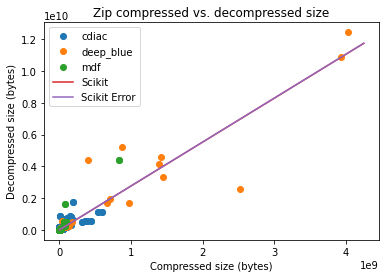

In [80]:
# Visualize compression vs. decompression
x1 = gzip_results_df.compressed_size
y1 = gzip_results_df.decompressed_size

# Figure 1
for name, group in gzip_results_df.groupby("origin"):
    plt.plot(group.compressed_size, group.decompressed_size, marker="o", linestyle="", label=name)

plt.plot(np.array([i for i in range(1, 45*10**8, 25*10**7)]), 
         gzip_sklearn_model.predict(np.array([i for i in range(1, 45*10**8, 25*10**7)]).reshape(-1, 1)), 
         label="Scikit")

plt.plot(np.array([i for i in range(1, 45*10**8, 25*10**7)]), 
         gzip_sklearn_model.predict(np.array([i for i in range(1, 45*10**8, 25*10**7)]).reshape(-1, 1)) + 7038058.413954257, 
         label="Scikit Error")

# plt.plot(np.array([i for i in range(1, 25*10**8, 25*10**7)]), 
#          zip_keras_predict(np.array([i for i in range(1, 25*10**8, 25*10**7)]).reshape(-1, 1)), 
#          label="Keras")

plt.legend()
plt.title("Zip compressed vs. decompressed size")
plt.xlabel("Compressed size (bytes)")
plt.ylabel("Decompressed size (bytes)")

## Tar Predictor

In [107]:
# Import decompression size .csv
tar_results_df = pd.read_csv("../data/tar_decompression_results.csv")

x = np.array(tar_results_df.compressed_size)
y = np.array(tar_results_df.decompressed_size)

In [108]:
# Train sklearn model
tar_sklearn_model = sklearn.linear_model.LinearRegression(fit_intercept=False)
tar_sklearn_model.fit(x.reshape(-1, 1), y)

y_pred = tar_sklearn_model.predict(x.reshape(-1, 1))

print(f"Line: {tar_sklearn_model.coef_}x + {tar_sklearn_model.intercept_}")
print(f"R^2: {tar_sklearn_model.score(x.reshape(-1, 1), y)}")
print(f"MSE: {sklearn.metrics.mean_squared_error(y, y_pred)}")
print(f"RMSE: {np.sqrt(sklearn.metrics.mean_squared_error(y, y_pred))}")
print(f"MPE: {MeanPositiveError(y, y_pred)}")

Line: [3.1911584]x + 0.0
R^2: 0.9762367912424945
MSE: 6.551587325313838e+17
RMSE: 809418762.1567614
MPE: 55223946.37318251


In [110]:
error = y_pred - y
np.quantile(error, 0.95)

595931136.9222465

Text(0, 0.5, 'Decompressed size (bytes)')

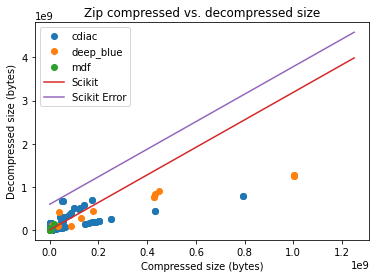

In [112]:
# Visualize compression vs. decompression
tar_results_df = tar_results_df[tar_results_df.decompressed_size < 1.5*10**9]

x1 = tar_results_df.compressed_size
y1 = tar_results_df.decompressed_size

# Figure 1
for name, group in tar_results_df.groupby("origin"):
    plt.plot(group.compressed_size, group.decompressed_size, marker="o", linestyle="", label=name)

plt.plot(np.array([i for i in range(1, 15*10**8, 25*10**7)]), 
         tar_sklearn_model.predict(np.array([i for i in range(1, 15*10**8, 25*10**7)]).reshape(-1, 1)), 
         label="Scikit")

plt.plot(np.array([i for i in range(1, 15*10**8, 25*10**7)]), 
         tar_sklearn_model.predict(np.array([i for i in range(1, 15*10**8, 25*10**7)]).reshape(-1, 1)) + 595931136.9222465, 
         label="Scikit Error")

# plt.plot(np.array([i for i in range(1, 25*10**8, 25*10**7)]), 
#          zip_keras_predict(np.array([i for i in range(1, 25*10**8, 25*10**7)]).reshape(-1, 1)), 
#          label="Keras")

plt.legend()
plt.title("Zip compressed vs. decompressed size")
plt.xlabel("Compressed size (bytes)")
plt.ylabel("Decompressed size (bytes)")